# Client Churn Analysis

In [31]:
import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
# Download dataset
!kaggle datasets download -d yeanzc/telco-customer-churn-ibm-dataset

Dataset URL: https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset
License(s): other
telco-customer-churn-ibm-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## EDA

In [33]:
# Extract dataset
import zipfile

zip_file = 'telco-customer-churn-ibm-dataset.zip'
with zipfile.ZipFile(zip_file, 'r') as file:
    file.extractall()

In [34]:
# Read the Excel file and see the structure of dataset
df = pd.read_excel('Telco_customer_churn.xlsx')
df.shape

(7043, 33)

In [35]:
# Show column names
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [36]:
# Convert to lowercase and replace blankspaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Adjust customer_id column name
df.columns = df.columns.str.replace('customerid', 'customer_id')

# Verify column names after adjusting
print(df.columns.tolist())

['customer_id', 'count', 'country', 'state', 'city', 'zip_code', 'lat_long', 'latitude', 'longitude', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure_months', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'churn_label', 'churn_value', 'churn_score', 'cltv', 'churn_reason']


In [37]:
# Show first rows of the dataset
df.head()

,customer_id,count,country,state,city,zip_code,lat_long,latitude,longitude,gender,...,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn_label,churn_value,churn_score,cltv,churn_reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [38]:
# Check NULL data
df.isnull().sum()

customer_id             0
count                   0
country                 0
state                   0
city                    0
zip_code                0
lat_long                0
latitude                0
longitude               0
gender                  0
senior_citizen          0
partner                 0
dependents              0
tenure_months           0
phone_service           0
multiple_lines          0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
contract                0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn_label             0
churn_value             0
churn_score             0
cltv                    0
churn_reason         5174
dtype: int64

In [39]:
# Check unique reasons to pick the best for filling na values
df['churn_reason'].unique()

array(['Competitor made better offer', 'Moved',
       'Competitor had better devices',
       'Competitor offered higher download speeds',
       'Competitor offered more data', 'Price too high',
       'Product dissatisfaction', 'Service dissatisfaction',
       'Lack of self-service on Website', 'Network reliability',
       'Limited range of services',
       'Lack of affordable download/upload speed',
       'Long distance charges', 'Extra data charges', "Don't know",
       'Poor expertise of online support',
       'Poor expertise of phone support', 'Attitude of service provider',
       'Attitude of support person', 'Deceased', nan], dtype=object)

In [40]:
# Fill na values with unknown reason
df['churn_reason'].fillna("Don't know", inplace=True)

In [41]:
# Check data types
df.dtypes

customer_id           object
count                  int64
country               object
state                 object
city                  object
zip_code               int64
lat_long              object
latitude             float64
longitude            float64
gender                object
senior_citizen        object
partner               object
dependents            object
tenure_months          int64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges         object
churn_label           object
churn_value            int64
churn_score            int64
cltv                   int64
churn_reason          object
dtype: object

In [42]:
# Convert total charges column to numeric type
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

In [43]:
# Fill NAs with the value of the dataset's median
df['total_charges'] = df['total_charges'].fillna(df['total_charges'].median())

In [44]:
# Convert specific columnt to int/float type
df['tenure_months'] = df['tenure_months'].astype(int)
df['monthly_charges'] = df['monthly_charges'].astype(float)

In [45]:
# Delete redundant data
df.drop_duplicates(inplace=True)

In [46]:
# See descriptive stats
df.describe()

,count,zip_code,latitude,longitude,tenure_months,monthly_charges,total_charges,churn_value,churn_score,cltv
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,2281.916928,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,2265.270398,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,18.800000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,402.225000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,1397.475000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,3786.600000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,8684.800000,1.000000,100.000000,6500.000000


## Visualization

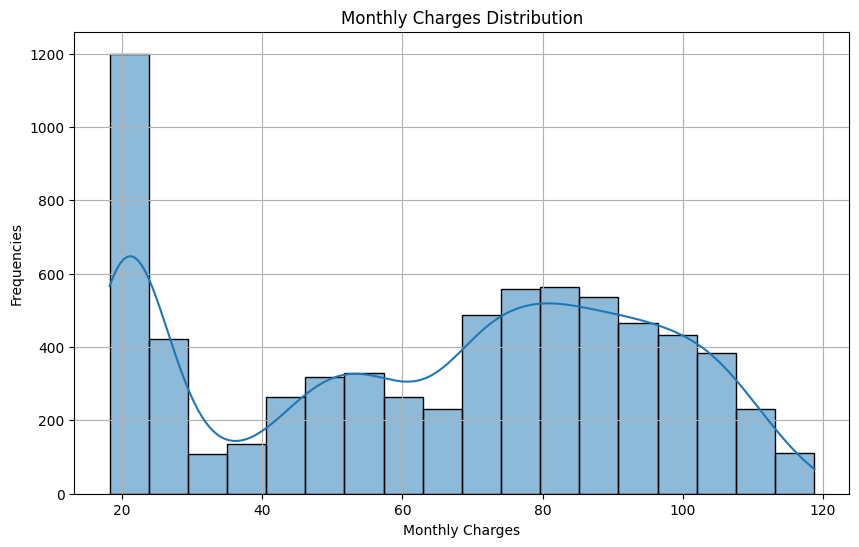

In [47]:
# Monthly charges histogram
plt.figure(figsize=(10,6))
sns.histplot(df['monthly_charges'], kde=True)
plt.title('Monthly Charges Distribution')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequencies')
plt.grid(True)
plt.show()

In [48]:
# Counting Churn and Non-Churn Clients
churn_distribution = df['churn_label'].value_counts()

# Show distribution
print(churn_distribution)

churn_label
No     5174
Yes    1869
Name: count, dtype: int64


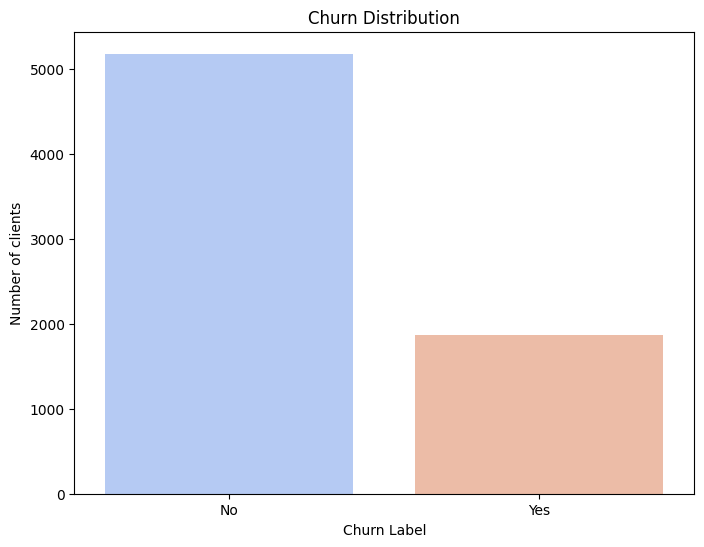

In [49]:
# Visualize Churn distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_distribution.index, y=churn_distribution.values, palette='coolwarm', hue=churn_distribution.index)
plt.title('Churn Distribution')
plt.xlabel('Churn Label')
plt.ylabel('Number of clients')
plt.show()

In [50]:
# Calculate class percentage
total_customers = churn_distribution.sum()
churn_percentage = churn_distribution / total_customers * 100

# Show percentage
print(churn_percentage)

churn_label
No     73.463013
Yes    26.536987
Name: count, dtype: float64


In [51]:
# Check relation between variables
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,count,zip_code,latitude,longitude,tenure_months,monthly_charges,total_charges,churn_value,churn_score,cltv
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip_code,NaN,1.000000,0.895743,-0.784271,0.001041,-0.004596,-0.001237,0.003346,-0.002769,-0.003562
latitude,NaN,0.895743,1.000000,-0.876779,-0.001631,-0.019899,-0.010168,-0.003384,-0.007684,0.000886
longitude,NaN,-0.784271,-0.876779,1.000000,-0.001678,0.024098,0.008977,0.004594,0.004260,0.000485
tenure_months,NaN,0.001041,-0.001631,-0.001678,1.000000,0.247900,0.825464,-0.352229,-0.224987,0.396406
monthly_charges,NaN,-0.004596,-0.019899,0.024098,0.247900,1.000000,0.650864,0.193356,0.133754,0.098693
total_charges,NaN,-0.001237,-0.010168,0.008977,0.825464,0.650864,1.000000,-0.199037,-0.123948,0.341723
churn_value,NaN,0.003346,-0.003384,0.004594,-0.352229,0.193356,-0.199037,1.000000,0.664897,-0.127463
churn_score,NaN,-0.002769,-0.007684,0.004260,-0.224987,0.133754,-0.123948,0.664897,1.000000,-0.079782
cltv,NaN,-0.003562,0.000886,0.000485,0.396406,0.098693,0.341723,-0.127463,-0.079782,1.000000


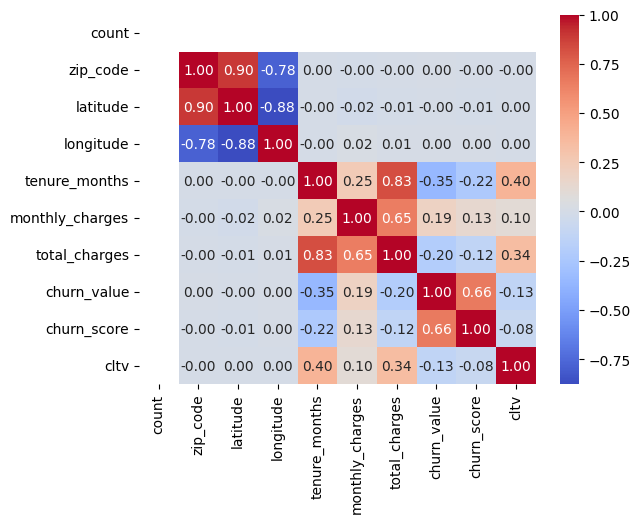

In [52]:
# Plotting relations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f');

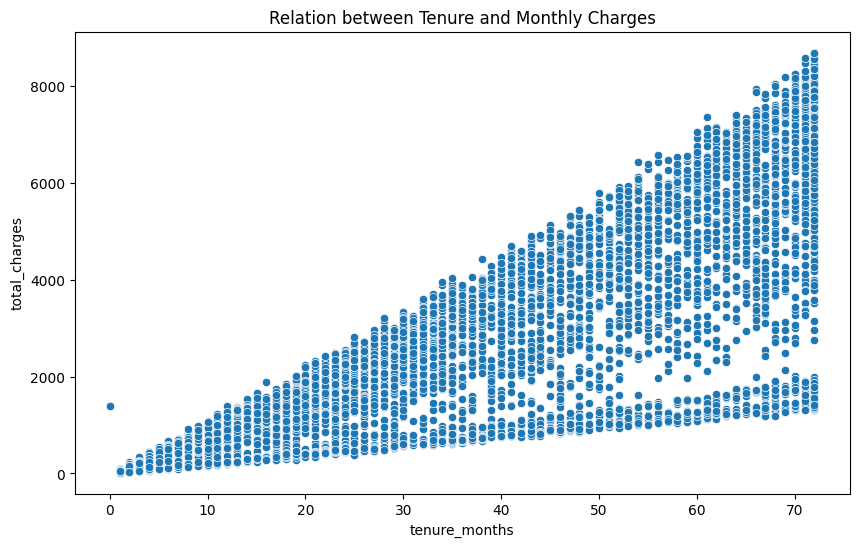

In [53]:
# Scatterplot of Tenure vs Monthly Charges
plt.figure(figsize=(10,6))
sns.scatterplot(x='tenure_months', y='total_charges', data=df)
plt.title('Relation between Tenure and Monthly Charges')
plt.show()

In [54]:
# Drop irrelevant columns
df = df.drop(['customer_id', 'country', 'state'], axis=1)

In [55]:
# List of categorical columns for one-hot encoding
categorical_cols = ['gender', 'lat_long', 'senior_citizen', 'partner', 'dependents',
                     'phone_service', 'multiple_lines', 'internet_service',
                     'online_security', 'online_backup', 'device_protection',
                     'tech_support', 'streaming_tv', 'streaming_movies',
                     'contract', 'paperless_billing', 'churn_reason', 'payment_method', 'city']

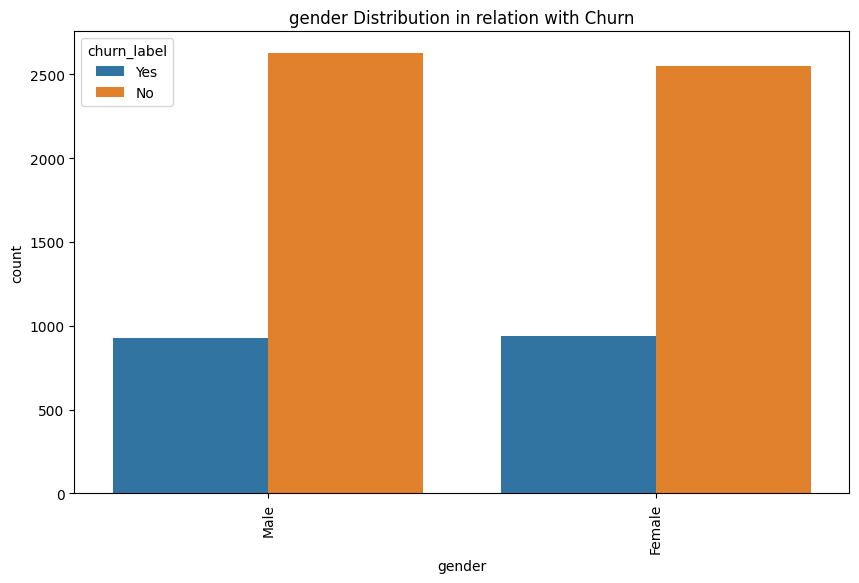

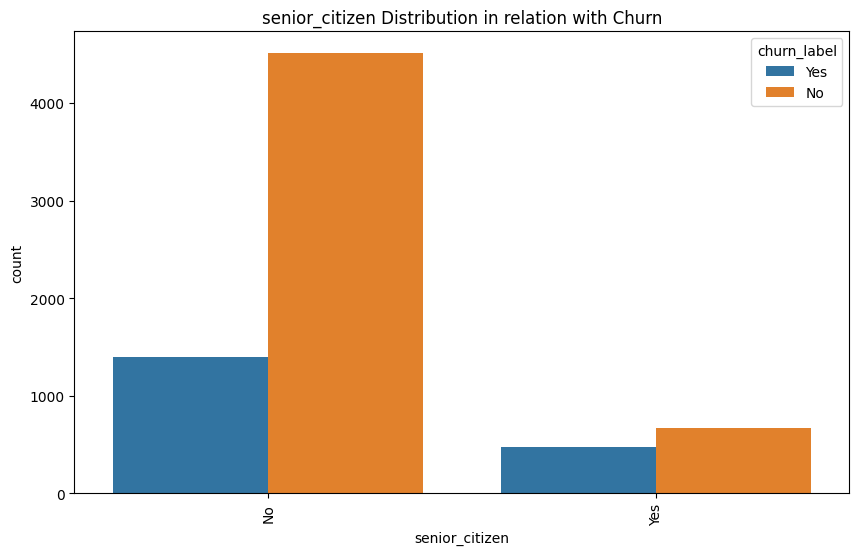

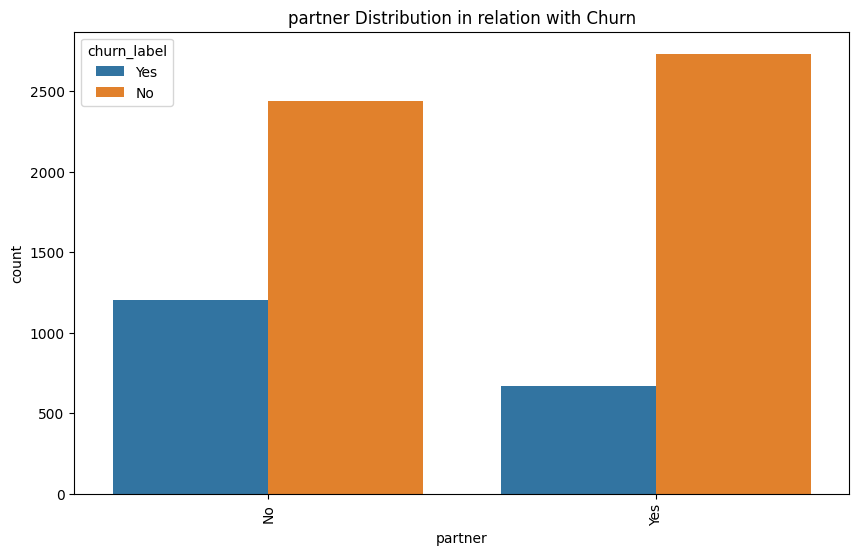

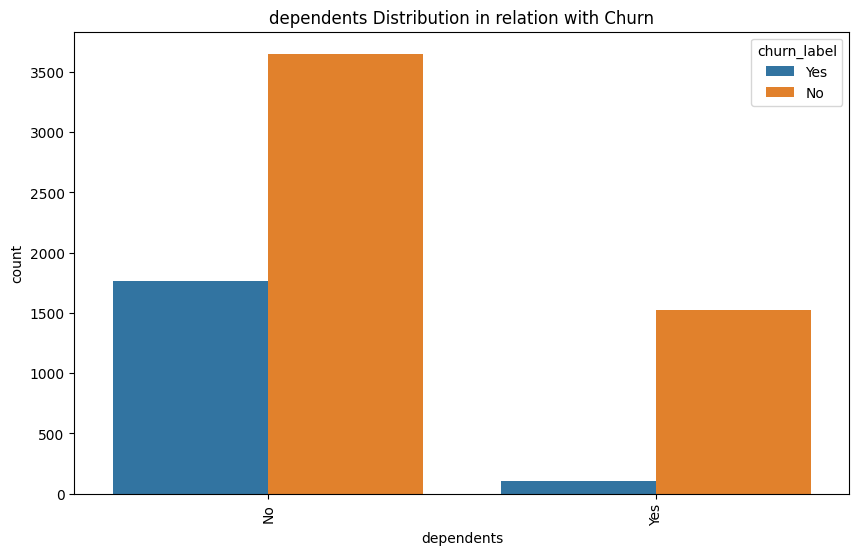

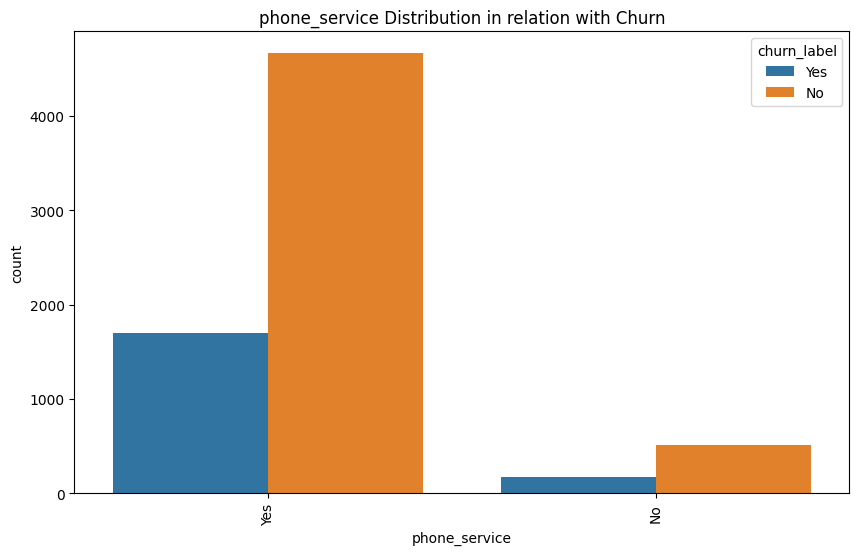

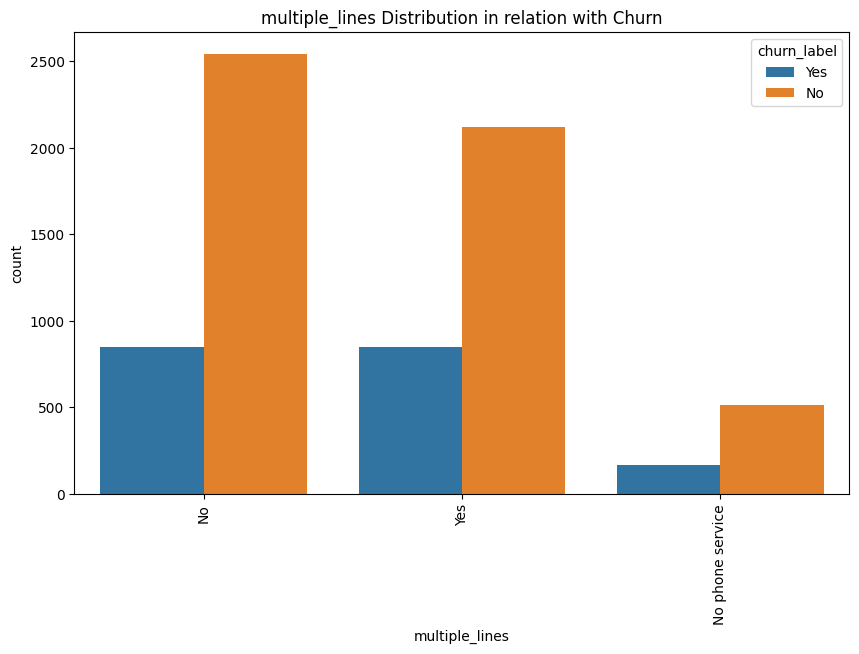

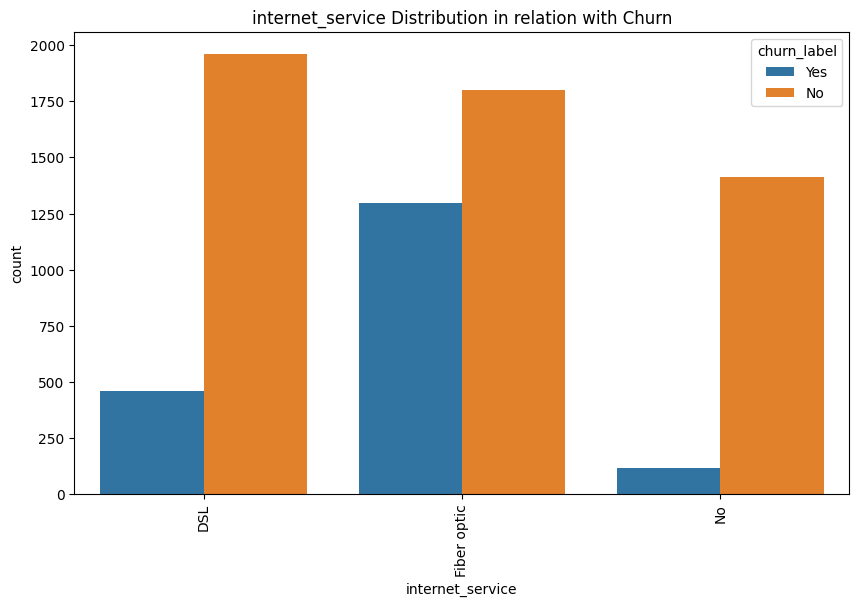

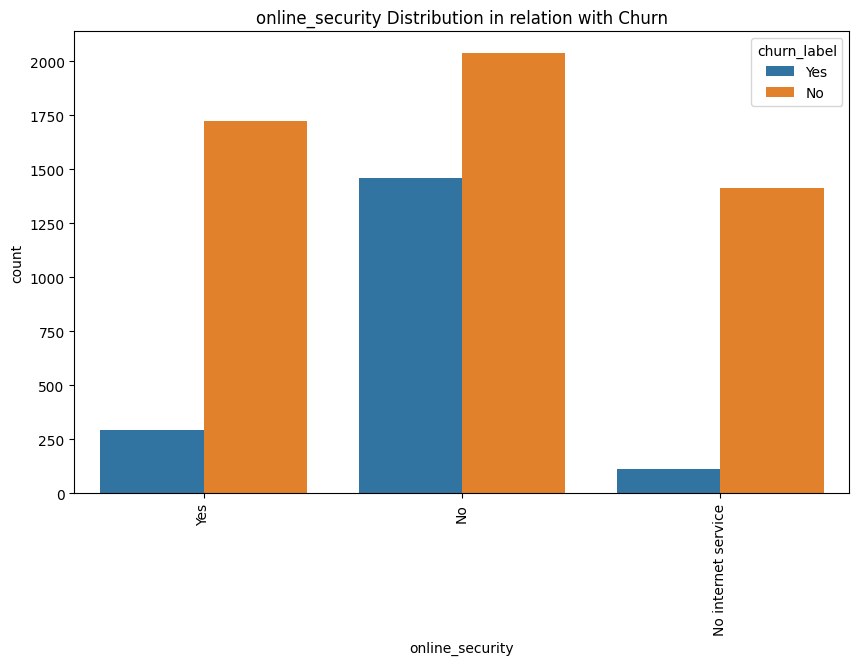

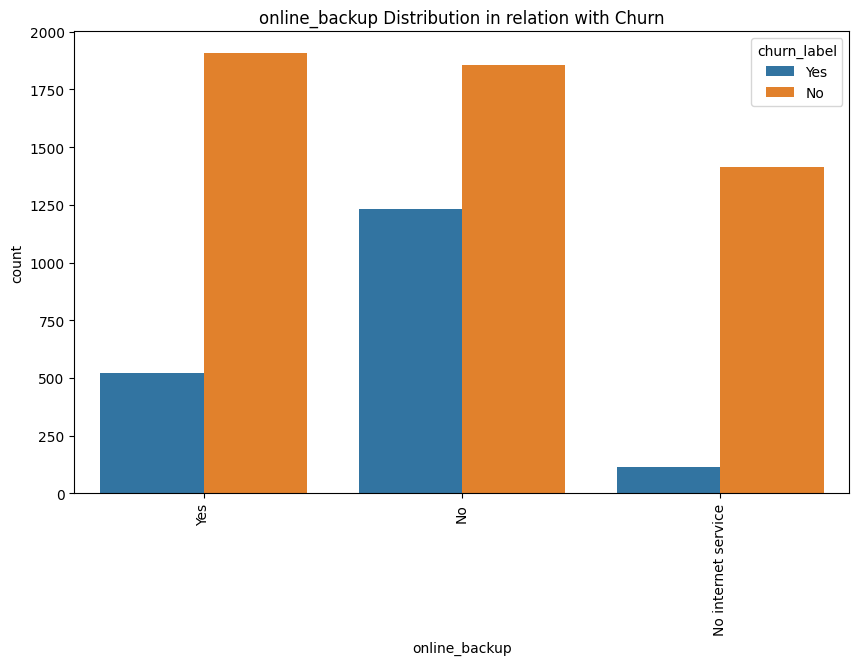

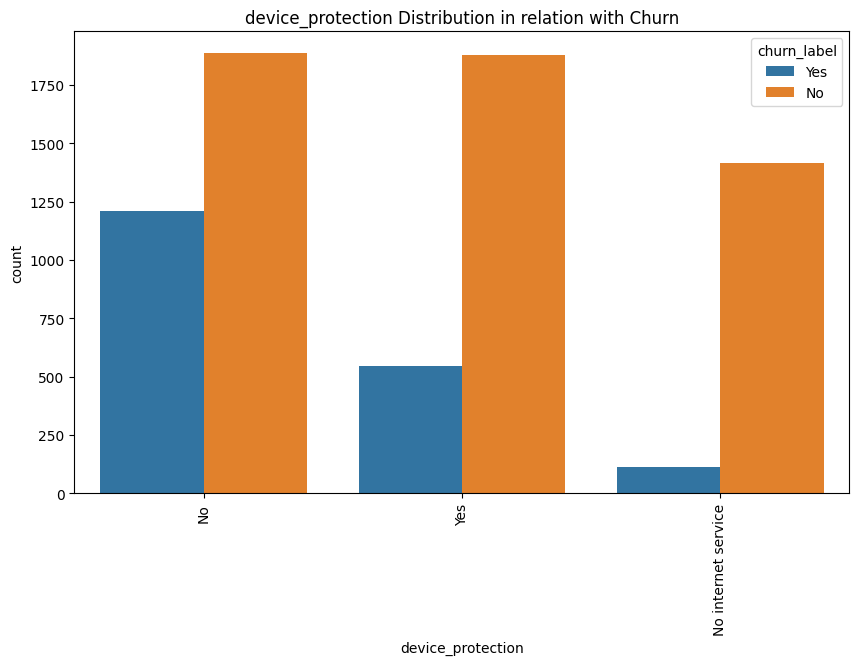

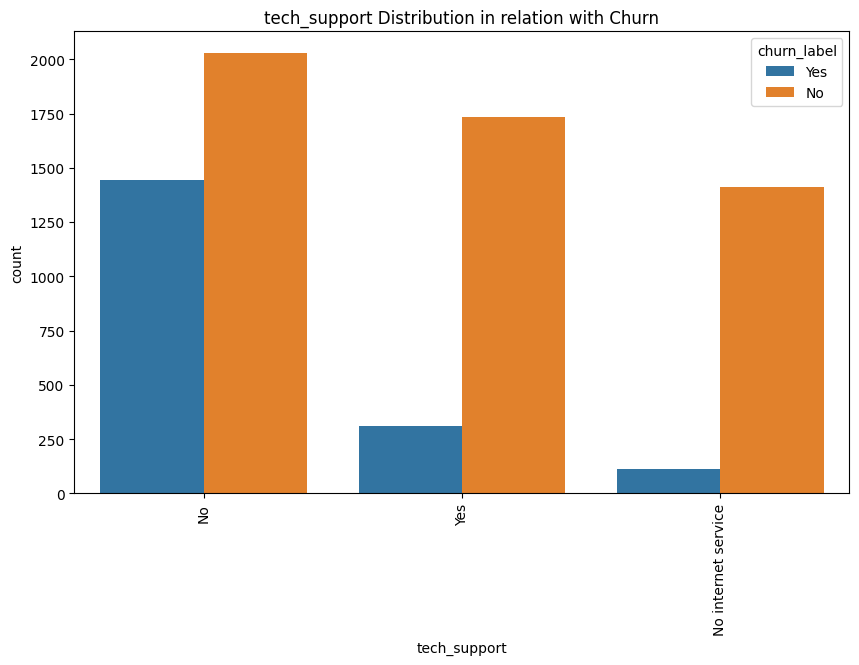

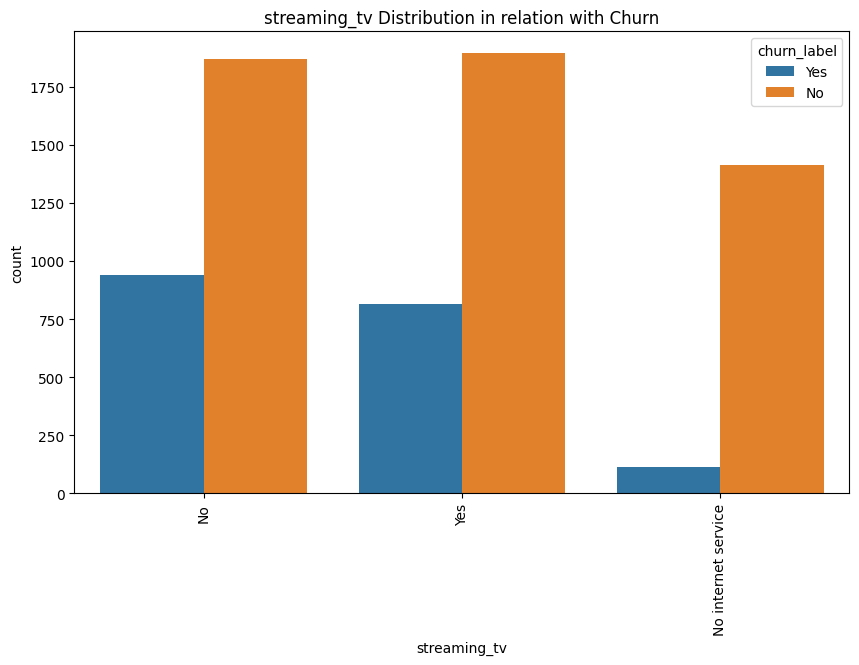

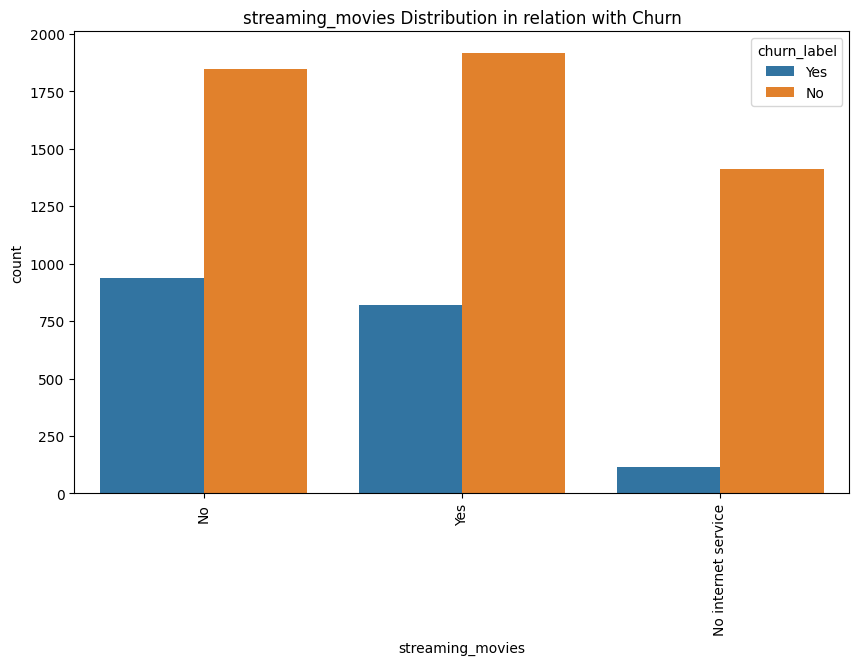

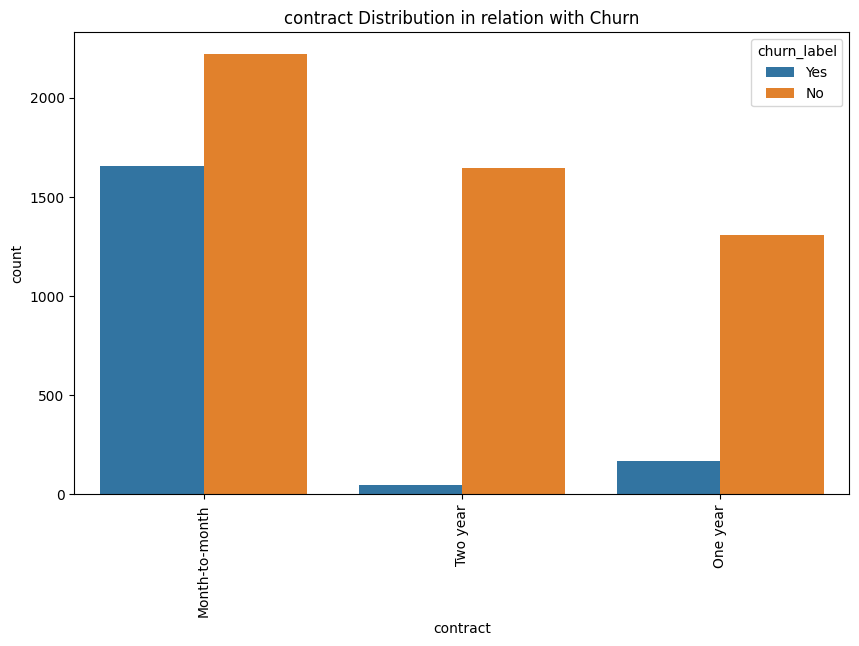

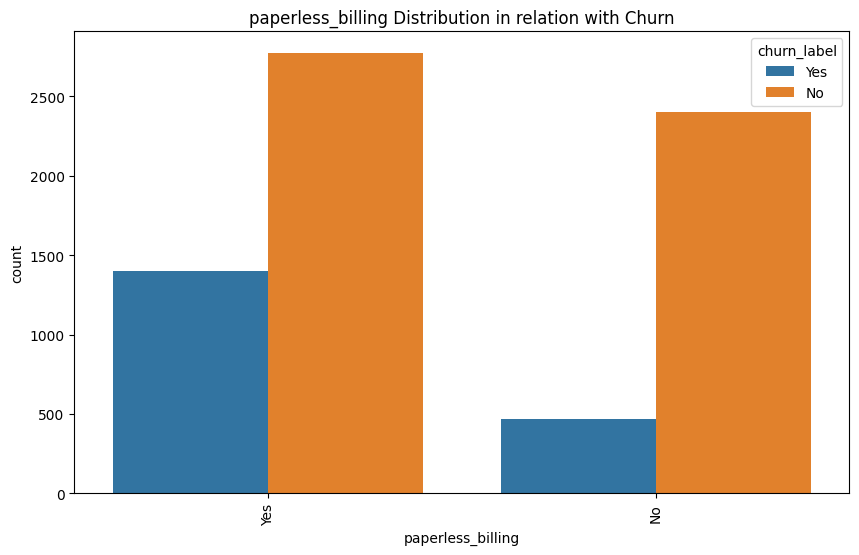

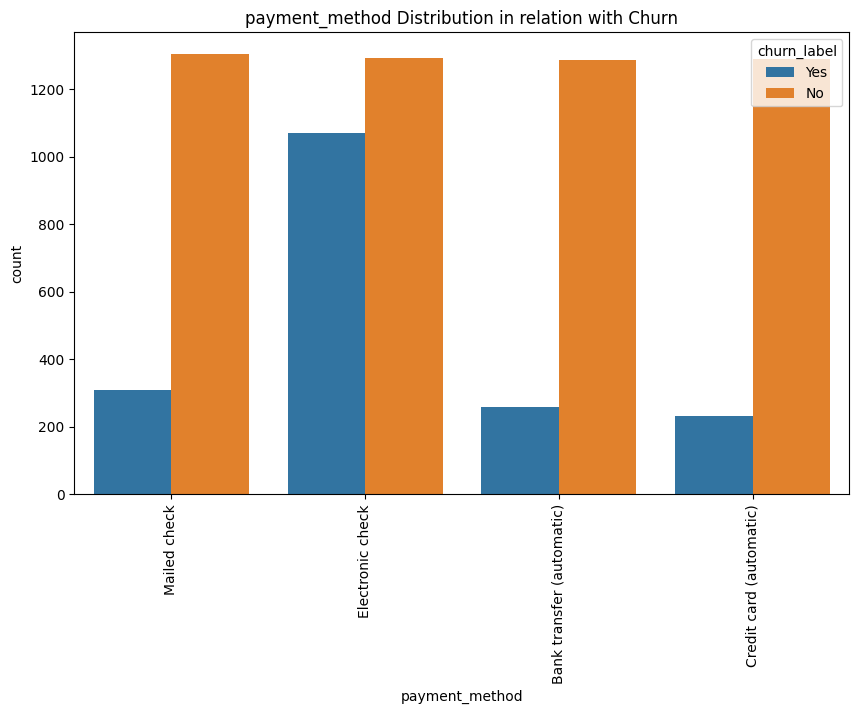

In [89]:
# Ignoring 'city', 'lat_long', and 'churn_reason' as their distributions are not descriptive
cols_to_ignore = ['city', 'lat_long', 'churn_reason']

for col in cols_to_ignore:
    if col in categorical_cols:
        categorical_cols.remove(col)

# Bar Plot of categorical variables
def plot_categorical_distribution(df, categorical_cols):
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='churn_label', data=df)
        plt.title(f'{col} Distribution in relation with Churn')
        plt.xticks(rotation=90)
        plt.show()

# Call to function
plot_categorical_distribution(df, categorical_cols)

## Making Predictions With Random Forest

In [57]:
# Check unique values and count NaNs by categorical column
for col in categorical_cols:
    print(f"Column: {col}")
    print(df[col].value_counts(dropna=False))  # Show frequencies including NaNs
    print(f"NaNs in '{col}': {df[col].isna().sum()} of {len(df)} rows\n")

# Testing cleaning with adjustments, for example, not removing 'nan' strings
def clean_data(df, categorical_cols):
    for col in categorical_cols:
        df[col] = df[col].astype(str)  # Ensuring Columns are Strings
        df = df[df[col].notna()]  # Keep rows where the column is not NaN
    return df

df_cleaned = clean_data(df, categorical_cols)

# Check if df has data after cleaning
if df_cleaned.empty:
    print("DataFrame is empty after the cleaning.")
else:
    print("DataFrame after the cleaning:")
    print(df_cleaned.head())
    print("Number of rows and columns after the cleaning:", df_cleaned.shape)

Column: gender
gender
Male      3555
Female    3488
Name: count, dtype: int64
NaNs in 'gender': 0 of 7043 rows

Column: lat_long
lat_long
33.964131, -118.272783    5
34.152875, -118.486056    5
32.912664, -116.635387    5
32.64164, -116.985026     5
32.607964, -117.059459    5
                         ..
37.4695, -120.672724      4
38.055562, -120.456298    4
38.244806, -120.417301    4
38.264262, -120.515133    4
39.191797, -120.212401    4
Name: count, Length: 1652, dtype: int64
NaNs in 'lat_long': 0 of 7043 rows

Column: senior_citizen
senior_citizen
No     5901
Yes    1142
Name: count, dtype: int64
NaNs in 'senior_citizen': 0 of 7043 rows

Column: partner
partner
No     3641
Yes    3402
Name: count, dtype: int64
NaNs in 'partner': 0 of 7043 rows

Column: dependents
dependents
No     5416
Yes    1627
Name: count, dtype: int64
NaNs in 'dependents': 0 of 7043 rows

Column: phone_service
phone_service
Yes    6361
No      682
Name: count, dtype: int64
NaNs in 'phone_service': 0 of 7043 

In [58]:
# Convert categorical columns to one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [59]:
# Map churn_label to numeric values
df_encoded['churn_label'] = df_encoded['churn_label'].map({'No': 0, 'Yes': 1})

In [60]:
# Split data into features and target
X = df_encoded.drop('churn_label', axis=1)
y = df_encoded['churn_label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Align X_train and X_test to have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1525    0]
 [   5  583]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1525
           1       1.00      0.99      1.00       588

    accuracy                           1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113



In [61]:
from sklearn.model_selection import GridSearchCV

# Define parameters to adjust
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create clasifier and GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Adjust GridSearchCV
grid_search.fit(X_train, y_train)

# Show best params
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [62]:
# Obtenain best GridSearchCV classifier
best_rf = grid_search.best_estimator_

# Re-train model with best params
best_rf.fit(X_train, y_train)

# Make predictions with optimized model
y_pred = best_rf.predict(X_test)

# Evaluate model
from sklearn.metrics import confusion_matrix, classification_report

print(f'Confussion Matrix: \n{confusion_matrix(y_test, y_pred)}\n')
print(f'Classification Report: \n {classification_report(y_test, y_pred)}\n')

Confussion Matrix: 
[[1525    0]
 [   3  585]]

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1525
           1       1.00      0.99      1.00       588

    accuracy                           1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113




In [63]:
from sklearn.model_selection import cross_val_score

# Cross Validation
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='accuracy')
print(f"Average Precision in Cross Validation: {cv_scores.mean()} ± {cv_scores.std()}")


Average Precision in Cross Validation: 0.9987223974127362 ± 0.0012210071155443485


In [64]:
# Obtain best GridSearchCV model
best_model = grid_search.best_estimator_

# Make predictions with best model
y_pred_best = best_model.predict(X_test)

# Optional: aggregate churn's probability
churn_prob_best = best_model.predict_proba(X_test)[:, 1]

# Aggregate predictions to test
X_test['predicted_churn'] = y_pred_best
X_test['churn_probability'] = churn_prob_best

# Save predictions in a CSV file
X_test.to_csv('predictions_best.csv', index=False)

# Show first rows of predictions file
print(X_test.head())

      count  zip_code   latitude   longitude  tenure_months  monthly_charges  \
185       1     93531  35.214982 -118.590490             15             85.9   
2715      1     95207  38.002125 -121.324979             18             56.8   
3825      1     94579  37.687264 -122.157280              2             20.0   
1807      1     91423  34.146957 -118.432138              6             84.2   
132       1     92563  33.581045 -117.147190             40            104.8   

      total_charges  churn_value  churn_score  cltv  ...  city_Yorkville  \
185         1269.55            1           96  3579  ...           False   
2715        1074.65            0           59  5558  ...           False   
3825          40.90            0           39  2237  ...           False   
1807         519.15            1           72  5834  ...           False   
132         4131.95            1           88  3492  ...           False   

      city_Yosemite National Park  city_Yountville  city_Yreka

In [65]:
# Check importances
importances = model.feature_importances_
indices = importances.argsort()

# Verify the number of features
print(f"Number of features in X_train: {X_train.shape[1]}")
print(f"Number of feature importances: {len(importances)}")

Number of features in X_train: 2835
Number of feature importances: 2835


In [66]:
# Define importances of features
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Show most important features
print(importances_df.head(20))


                                                Feature  Importance
1691                            churn_reason_Don't know    0.248627
7                                           churn_value    0.223648
8                                           churn_score    0.114006
4                                         tenure_months    0.028061
6                                         total_charges    0.020796
1685            churn_reason_Attitude of support person    0.016029
1683                                  contract_Two year    0.014927
1689          churn_reason_Competitor offered more data    0.013387
1688  churn_reason_Competitor offered higher downloa...    0.012968
1687          churn_reason_Competitor made better offer    0.012650
5                                       monthly_charges    0.011757
1705                    payment_method_Electronic check    0.011319
9                                                  cltv    0.009064
1664                                     depende

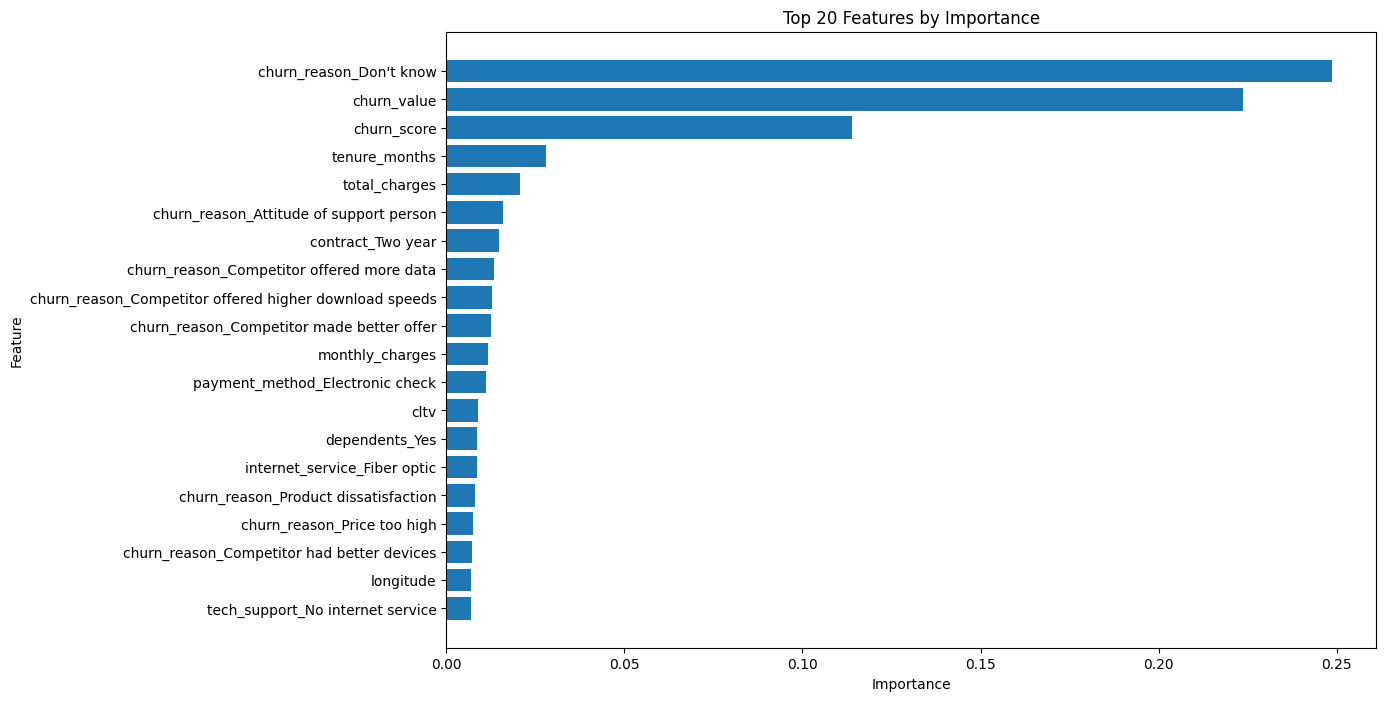

In [67]:
# Visualizae most important features
plt.figure(figsize=(12, 8))
plt.title('Top 20 Features by Importance')
plt.barh(importances_df.head(20)['Feature'], importances_df.head(20)['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Show highest feature on top
plt.show()

# Create Clusters and Make Analysis of Predictions

In [68]:
# Load predictions
df_predictions = pd.read_csv('predictions_best.csv')

# Show a resume of predictions
print(df_predictions[['predicted_churn', 'churn_probability']].describe())

       predicted_churn  churn_probability
count      2113.000000        2113.000000
mean          0.276858           0.273619
std           0.447551           0.394798
min           0.000000           0.000000
25%           0.000000           0.006667
50%           0.000000           0.038182
75%           1.000000           0.800000
max           1.000000           1.000000


In [69]:
# Define the umbral for high probability of churn
umbral = 0.8

# Filter clients with high probability of churn
high_probability_churn = df_predictions[df_predictions['churn_probability'] > umbral]

# Show a sample
print(high_probability_churn.sample(10))

      count  zip_code   latitude   longitude  tenure_months  monthly_charges  \
630       1     95722  39.003358 -121.022539             12            99.95   
45        1     93657  36.819628 -119.440414             57            39.30   
1798      1     92274  33.536040 -116.119222              1            75.30   
921       1     92629  33.477923 -117.705314              1            46.00   
1447      1     92110  32.765010 -117.199380             47            98.75   
1656      1     94611  37.828416 -122.216005              7            89.75   
5         1     95970  39.424957 -122.039307              8           105.50   
1111      1     90723  33.897122 -118.164432              1            85.00   
390       1     92694  33.569186 -117.640055              3           101.55   
1223      1     95258  38.169605 -121.310964             47            95.05   

      total_charges  churn_value  churn_score  cltv  ...  city_Yorkville  \
630         1132.75            1           

In [70]:
import statsmodels.api as sm

# Prepare data to logistic regression
X = df_predictions[['monthly_charges', 'total_charges']]
y = df_predictions['predicted_churn']

# Add a constant for the model
X = sm.add_constant(X)

# Adjust model of logistic regression
model = sm.Logit(y, X)
result = model.fit()

# Show resume of model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.478631
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        predicted_churn   No. Observations:                 2113
Model:                          Logit   Df Residuals:                     2110
Method:                           MLE   Df Model:                            2
Date:                Wed, 14 Aug 2024   Pseudo R-squ.:                  0.1887
Time:                        21:14:12   Log-Likelihood:                -1011.3
converged:                       True   LL-Null:                       -1246.6
Covariance Type:            nonrobust   LLR p-value:                6.869e-103
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.7225      0.162    -16.807      0.000      -3.040      -2.405
monthly_charge

In [71]:
# Prepare data for causal analysis
X_sens = df_predictions[['monthly_charges', 'total_charges']]
y_sens = df_predictions['predicted_churn']

# Adjust model
model_sens = sm.Logit(y_sens, sm.add_constant(X_sens))
result_sens = model_sens.fit()

# Show resume
print(result_sens.summary())

Optimization terminated successfully.
         Current function value: 0.478631
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        predicted_churn   No. Observations:                 2113
Model:                          Logit   Df Residuals:                     2110
Method:                           MLE   Df Model:                            2
Date:                Wed, 14 Aug 2024   Pseudo R-squ.:                  0.1887
Time:                        21:14:12   Log-Likelihood:                -1011.3
converged:                       True   LL-Null:                       -1246.6
Covariance Type:            nonrobust   LLR p-value:                6.869e-103
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.7225      0.162    -16.807      0.000      -3.040      -2.405
monthly_charge

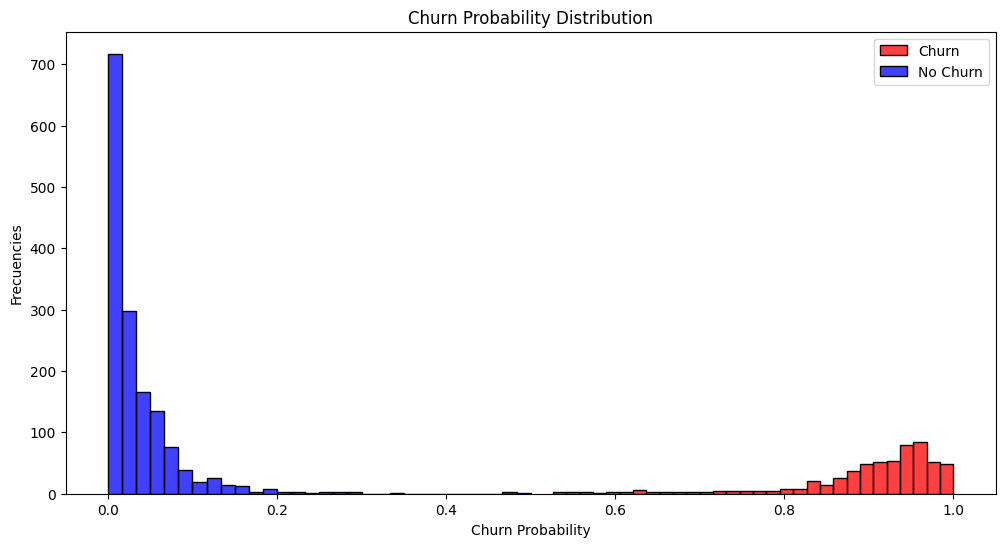

In [72]:
# Visualize probability of churn by segment
plt.figure(figsize=(12, 6))
sns.histplot(df_predictions[df_predictions['predicted_churn'] == 1]['churn_probability'], bins=30, color='red', label='Churn')
sns.histplot(df_predictions[df_predictions['predicted_churn'] == 0]['churn_probability'], bins=30, color='blue', label='No Churn')
plt.legend()
plt.title('Churn Probability Distribution')
plt.xlabel('Churn Probability')
plt.ylabel('Frecuencies')
plt.show()

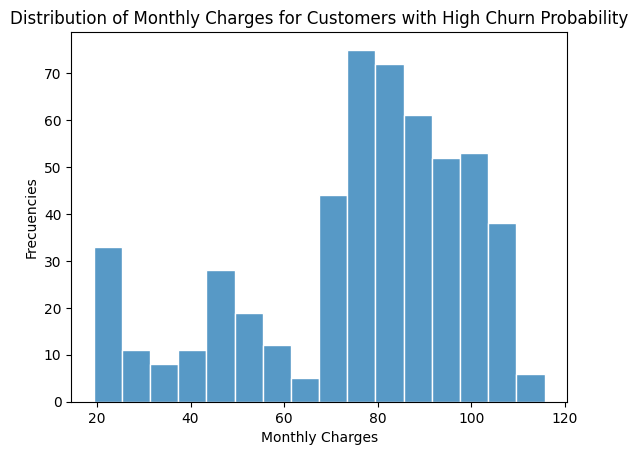

In [73]:
# Histogram of monthly charges for clients with high churn probability
sns.histplot(high_probability_churn['monthly_charges'], edgecolor='white')
plt.title('Distribution of Monthly Charges for Customers with High Churn Probability')
plt.xlabel('Monthly Charges')
plt.ylabel('Frecuencies')
plt.show()

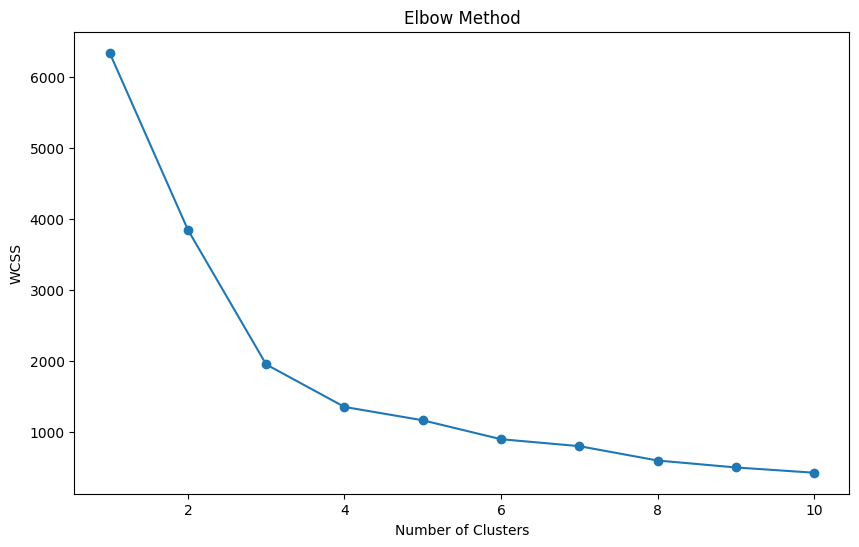

In [74]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features = df_predictions[['churn_probability', 'monthly_charges', 'total_charges']]

# Estandarize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Calculte WCSS for ditferent number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


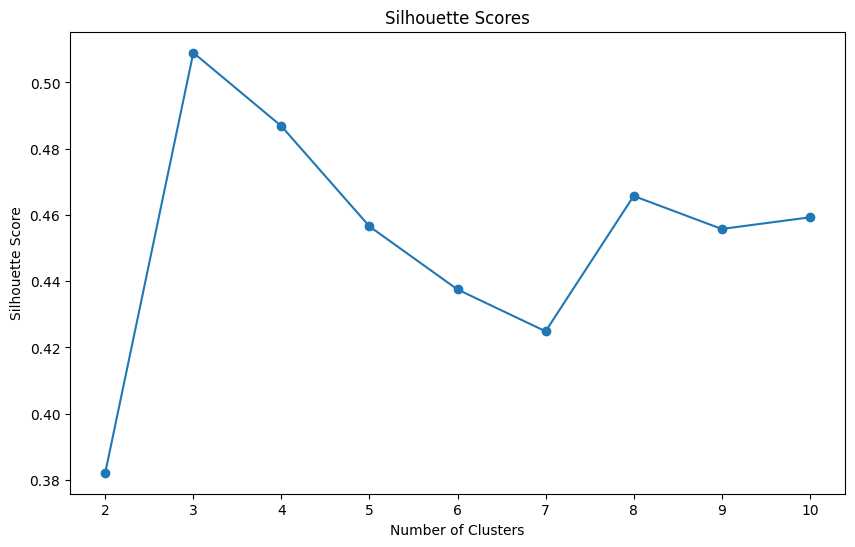

In [75]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for different number of clusters
silhouette_scores = []
for i in range(2, 11):  # Debe ser al menos 2 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, clusters)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [76]:
# Apply clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster to DataFrame
df_predictions['segment'] = clusters

# Show results
print(df_predictions.head())

   count  zip_code   latitude   longitude  tenure_months  monthly_charges  \
0      1     93531  35.214982 -118.590490             15             85.9   
1      1     95207  38.002125 -121.324979             18             56.8   
2      1     94579  37.687264 -122.157280              2             20.0   
3      1     91423  34.146957 -118.432138              6             84.2   
4      1     92563  33.581045 -117.147190             40            104.8   

   total_charges  churn_value  churn_score  cltv  ...  \
0        1269.55            1           96  3579  ...   
1        1074.65            0           59  5558  ...   
2          40.90            0           39  2237  ...   
3         519.15            1           72  5834  ...   
4        4131.95            1           88  3492  ...   

   city_Yosemite National Park  city_Yountville  city_Yreka  city_Yuba City  \
0                        False            False       False           False   
1                        False      

In [77]:
# Obtaint descriptive stats by segment
segment_stats = df_predictions.groupby('segment').agg({
    'monthly_charges': ['mean', 'std', 'min', 'max'],
    'total_charges': ['mean', 'std', 'min', 'max'],
    'churn_probability': ['mean']
})

print(segment_stats)

        monthly_charges                           total_charges               \
                   mean        std    min     max          mean          std   
segment                                                                        
0             73.393796  23.211123  19.30  110.85   1158.663148  1341.471047   
1             42.739520  22.619590  18.40  100.20    991.123362   850.810498   
2             92.257154  14.532392  55.65  118.75   5052.819863  1753.677451   

                          churn_probability  
             min      max              mean  
segment                                      
0          19.30  5549.40          0.908321  
1          19.00  3838.20          0.037835  
2        1275.65  8672.45          0.080679  


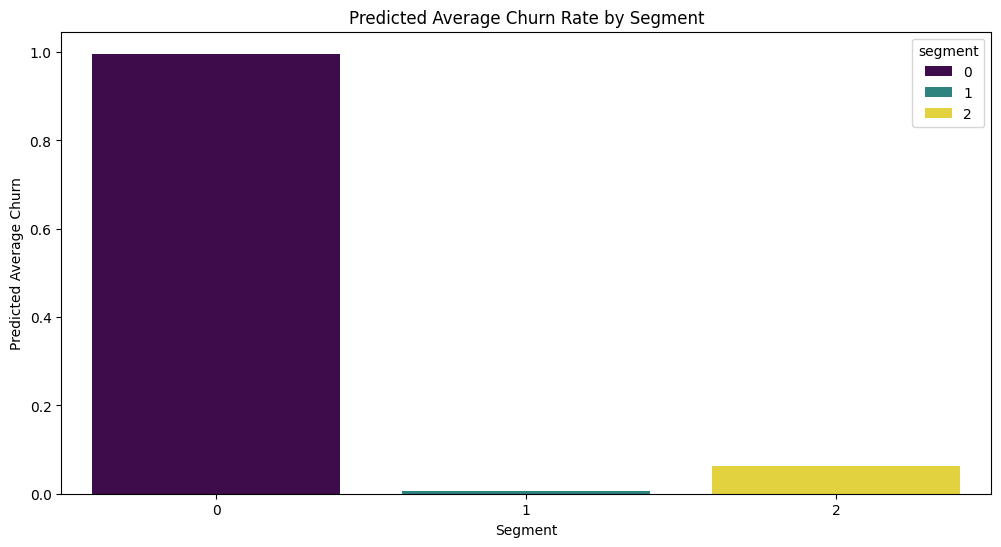

In [78]:
# Group by segment and calculate predicted average churn rate by segment
churn_by_segment = df_predictions.groupby('segment')['predicted_churn'].mean().reset_index()

# Plot the average churn rate by segment
plt.figure(figsize=(12, 6))
sns.barplot(x='segment', y='predicted_churn', data=churn_by_segment, palette='viridis', hue='segment')
plt.title('Predicted Average Churn Rate by Segment')
plt.xlabel('Segment')
plt.ylabel('Predicted Average Churn')
plt.xticks(rotation=0)
plt.show()

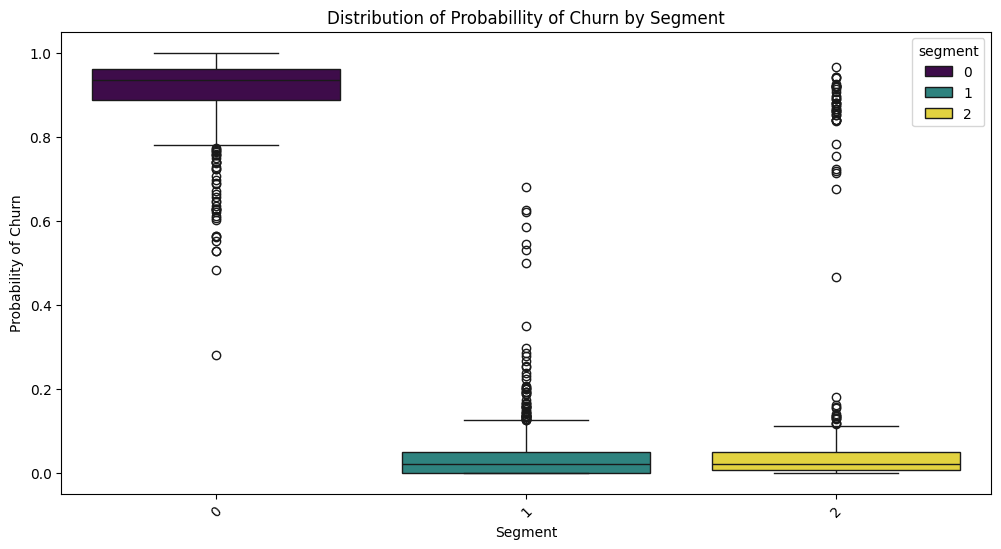

In [79]:
# Plot the probabillity of churn by segment
plt.figure(figsize=(12, 6))
sns.boxplot(x='segment', y='churn_probability', data=df_predictions, palette='viridis', hue='segment')
plt.title('Distribution of Probabillity of Churn by Segment')
plt.xlabel('Segment')
plt.ylabel('Probability of Churn')
plt.xticks(rotation=45)
plt.show()


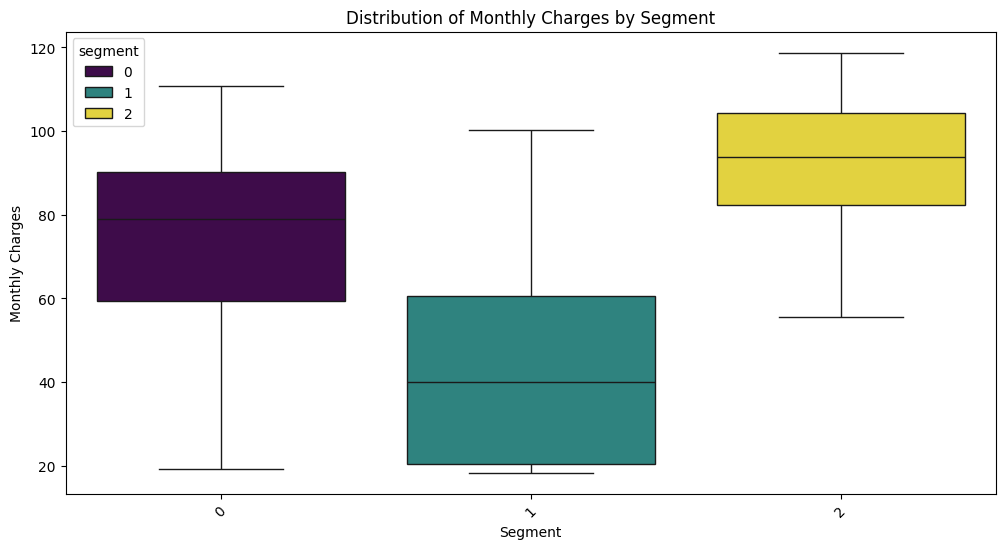

In [80]:
# Monthly Charges by Segment
plt.figure(figsize=(12, 6))
sns.boxplot(x='segment', y='monthly_charges', data=df_predictions, palette='viridis', hue='segment')
plt.title('Distribution of Monthly Charges by Segment')
plt.xlabel('Segment')
plt.ylabel('Monthly Charges')
plt.xticks(rotation=45)
plt.show()


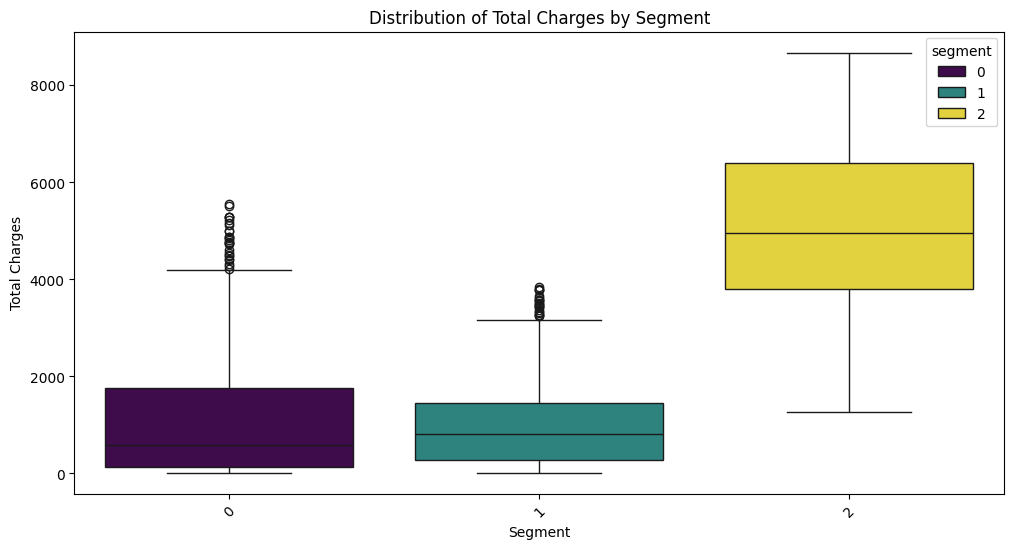

In [81]:
# Total Charges by Segment
plt.figure(figsize=(12, 6))
sns.boxplot(x='segment', y='total_charges', data=df_predictions, palette='viridis', hue='segment')
plt.title('Distribution of Total Charges by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Charges')
plt.xticks(rotation=45)
plt.show()

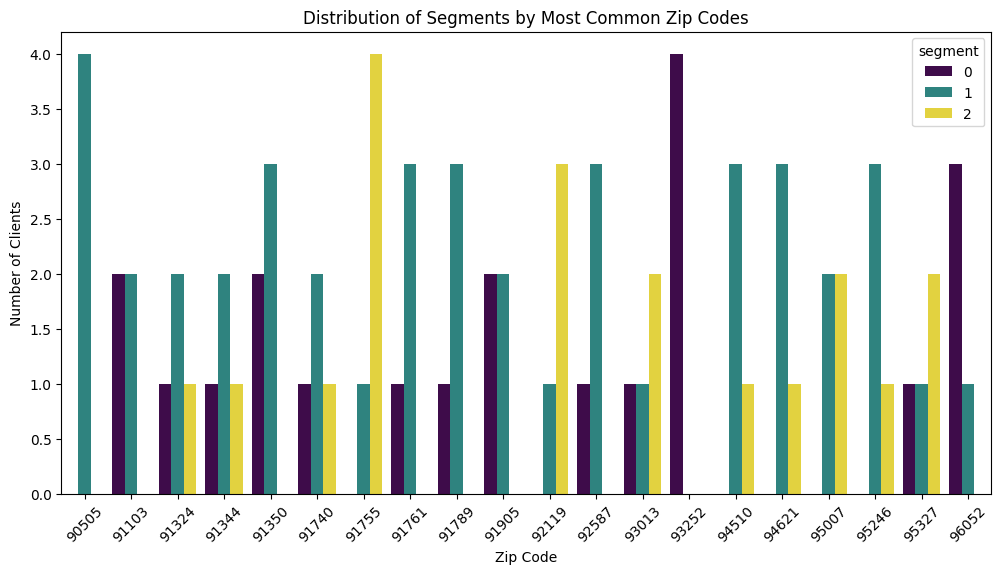

In [82]:
# Select most common zip codes
top_zip_codes = df_predictions['zip_code'].value_counts().head(20).index
subset = df_predictions[df_predictions['zip_code'].isin(top_zip_codes)]

# Plot the zip codes
plt.figure(figsize=(12, 6))
sns.countplot(x='zip_code', hue='segment', data=subset, palette='viridis')
plt.title('Distribution of Segments by Most Common Zip Codes')
plt.xlabel('Zip Code')
plt.ylabel('Number of Clients')
plt.xticks(rotation=45)
plt.show()

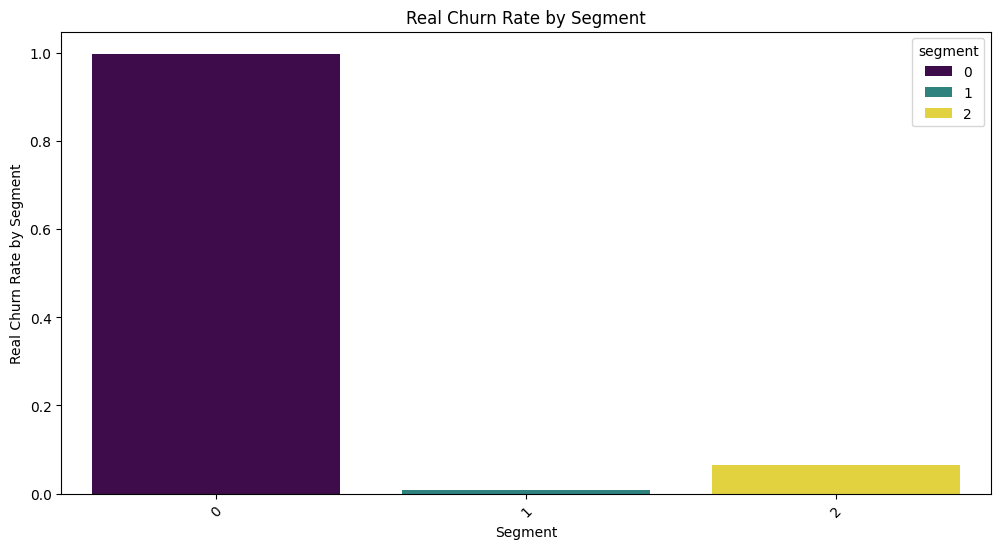

In [83]:
# Real churn rate by segment
churn_real_by_segment = df_predictions.groupby('segment')['churn_value'].mean().reset_index()

# Plot real churn rate by segment
plt.figure(figsize=(12, 6))
sns.barplot(x='segment', y='churn_value', data=churn_real_by_segment, palette='viridis', hue='segment')
plt.title('Real Churn Rate by Segment')
plt.xlabel('Segment')
plt.ylabel('Real Churn Rate by Segment')
plt.xticks(rotation=45)
plt.show()


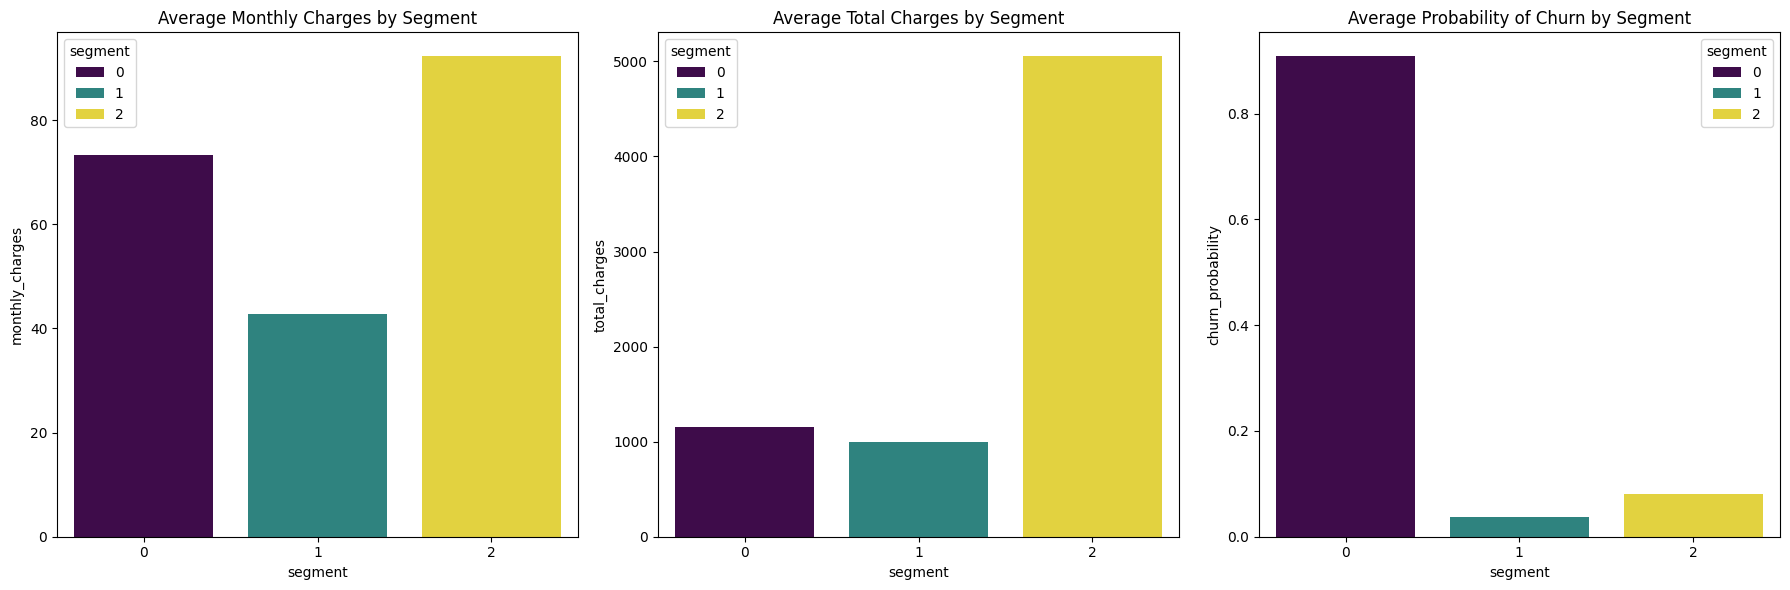

In [84]:
# Plot of means of 'monthly_charges', 'total_charges', and 'churn_probability' by segment
segment_means = df_predictions.groupby('segment').mean().reset_index()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot of mean monthly charges
sns.barplot(x='segment', y='monthly_charges', data=segment_means, ax=ax[0], palette='viridis', hue='segment', dodge=None)
ax[0].set_title('Average Monthly Charges by Segment')

# Plot of mean total charges
sns.barplot(x='segment', y='total_charges', data=segment_means, ax=ax[1], palette='viridis', hue='segment', dodge=None)
ax[1].set_title('Average Total Charges by Segment')

# Plot of mean churn probability
sns.barplot(x='segment', y='churn_probability', data=segment_means, ax=ax[2], palette='viridis', hue='segment', dodge=None)
ax[2].set_title('Average Probability of Churn by Segment')

plt.tight_layout()
plt.show()

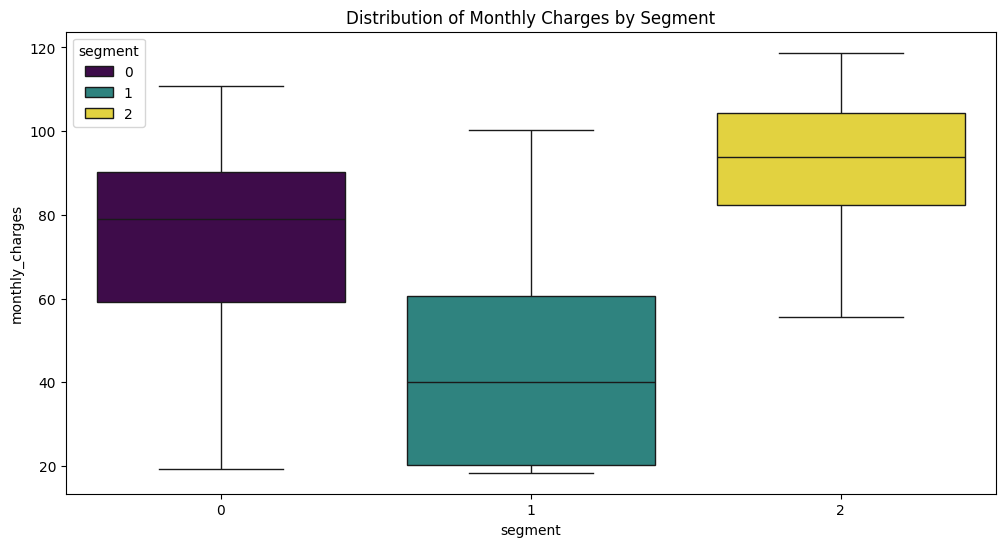

In [85]:
# Visualize distribution of 'monthly_charges' by segment
plt.figure(figsize=(12, 6))
sns.boxplot(x='segment', y='monthly_charges', data=df_predictions, palette='viridis', hue='segment')
plt.title('Distribution of Monthly Charges by Segment')
plt.show()

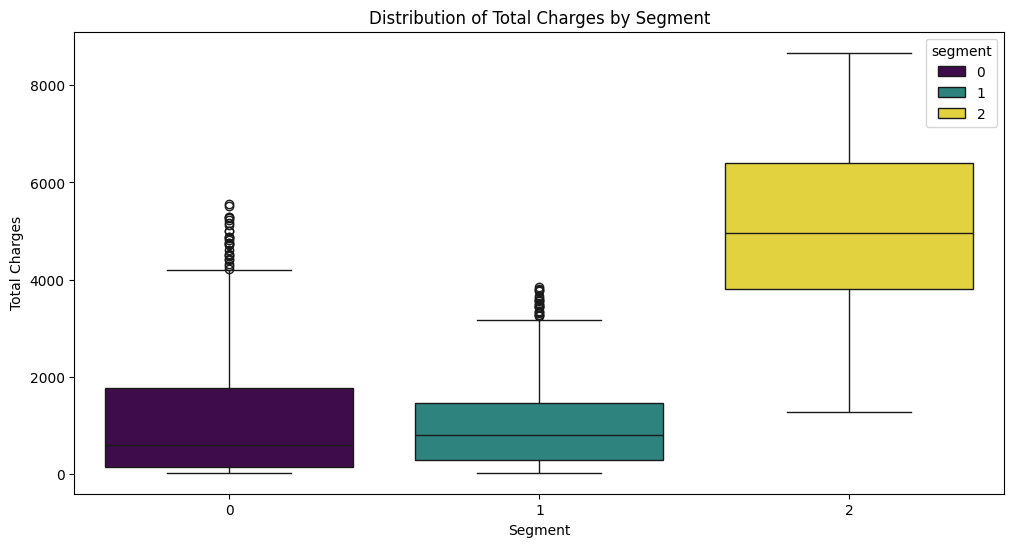

In [86]:
# Plot distribution of 'total_charges' by segment
plt.figure(figsize=(12, 6))
sns.boxplot(x='segment', y='total_charges', data=df_predictions, palette='viridis', hue='segment')
plt.title('Distribution of Total Charges by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Charges')
plt.show()

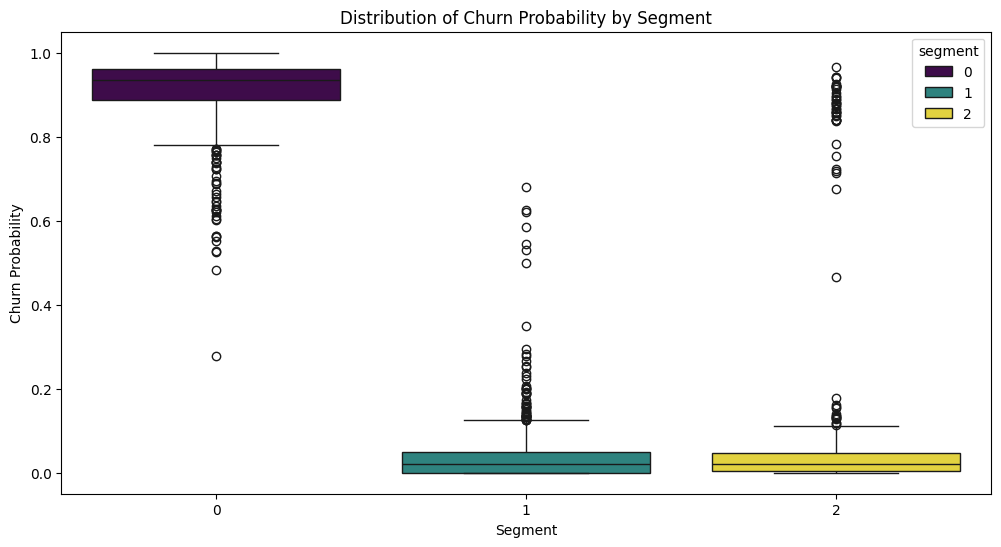

In [87]:
# Gráfico de distribución de 'churn_probability' por segmento
plt.figure(figsize=(12, 6))
sns.boxplot(x='segment', y='churn_probability', data=df_predictions, palette='viridis', hue='segment')
plt.title('Distribution of Churn Probability by Segment')
plt.xlabel('Segment')
plt.ylabel('Churn Probability')
plt.show()

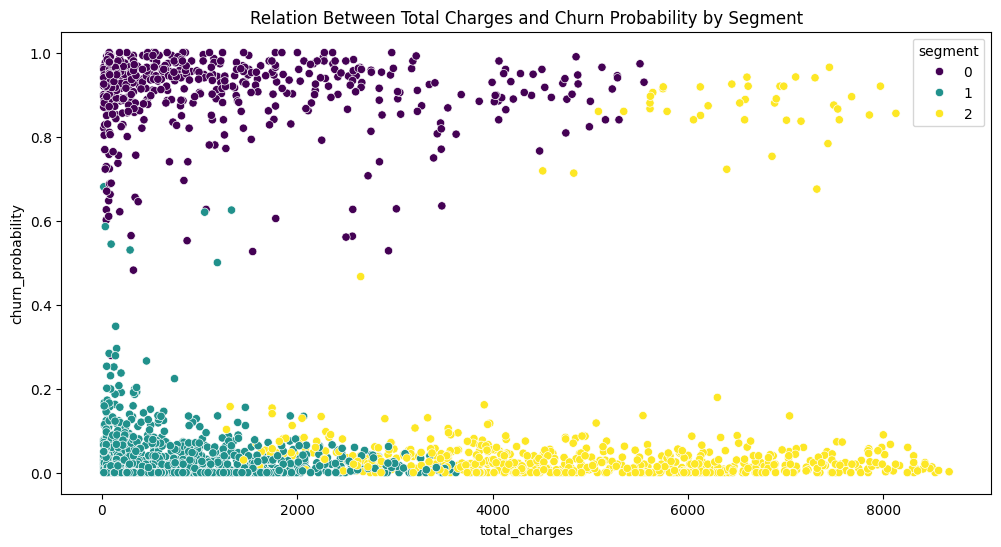

In [88]:
# Visualize relation between 'total_charges' and 'churn_probability' by segment
plt.figure(figsize=(12, 6))
sns.scatterplot(x='total_charges', y='churn_probability', palette='viridis', hue='segment', data=df_predictions)
plt.title('Relation Between Total Charges and Churn Probability by Segment')
plt.show()

## Summary

### Model: Random Forest
- Parameters:
    - n_estimators: 100
    - max_depth: None
    - min_samples_split: 10
    - min_samples_leaf: 2
    - Métricas de Evaluación:
- Accuracy Score: 0.77

### Segmentation Analysis Results

- Overview of the Analysis:
    - Segmentation analysis was conducted using a K-Means clustering model with an optimal number of 3 clusters, based on the silhouette method. 
    - The features churn_probability, monthly_charges, and total_charges were used to segment the data.

### Segment Characteristics:

- Segment 0:
    - Monthly Charges: Average of $73.39, ranging from $19.30 to $110.85.
    - Total Charges: Average of $1158.66, with a range from $19.30 to $5549.40.
    - Churn Probability: Average of 0.91, with values between 0.19 and 0.91.
- Description: This group consists of customers with high monthly and total charges but a high probability of churn. Despite their high investment, these customers show dissatisfaction or seek more economical options.

- Segment 1:
    - Monthly Charges: Average of $42.74, ranging from $18.40 to $100.20.
    - Total Charges: Average of $991.12, ranging from $18.40 to $3838.20.
    - Churn Probability: Average of 0.04, ranging from 0.00 to 0.37.
- Description: Customers in this segment have moderate monthly and total charges and a low probability of churn. They are stable and satisfied customers with an affordable cost.

- Segment 2:
    - Monthly Charges: Average of $92.26, ranging from $55.65 to $118.75.
    - Total Charges: Average of $5052.82, ranging from $1275.65 to $8672.45.
    - Churn Probability: Average of 0.08, with values between 0.08 and 0.81.
- Description: This segment includes customers with high monthly and total charges but a low probability of churn. These customers show a high investment in the service and tend to be satisfied, despite the high cost.

### Conclusions:

- The clustering analysis has provided a clear insight into how different customer segments vary in terms of expenses and churn probability. 
- This segmentation allows the company to identify areas for improving customer retention and adjust their pricing and service strategies to better meet the needs of each group.
